# Part 0: Installation
Let's start with jupyter configuration


In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

# Installation of Rasa

#### In your environment run:
!{python} -m pip install -U rasa_core==0.9.6 rasa_nlu[spacy];

#### as well as install a language model:
!{python} -m spacy download en_core_web_md
!{python} -m spacy link en_core_web_md en 

In [2]:
import sys
python = sys.executable



Let's test the installation - we should have rasa_nlu: 0.12.3 and rasa_core: 0.9.6 installed, and spacy model should be available.

In [3]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

rasa_nlu: 0.12.3 rasa_core: 0.9.6
Loading spaCy language model...
Hello world!


### Some additional Tools needed
To do some of the visualizations you will also need graphviz. If you don't have graphviz installed, and this doesn't work: don't worry. I'll show you the graph and besides that visualization everything else will work.

!{python} --m  pip  install pygraphviz;

## Creating the training data for language understanding model
Lets create some training data here, grouping user messages by their intents. The intent describes what the messages mean. Another important part of training data are entities - pieces of information which help a chatbot understand what specifically a user is asking about.

In [4]:
nlu_md = """
## intent:greet
- hey
- hello there
- hi
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:mood_affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:mood_deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- feeling like a king
- wonderful
- I am feeling very good
- I am great
- I am amazing
- I am going to save the world
- super
- extremely good
- so so perfect
- so good
- so perfect

## intent:mood_unhappy
- my day was horrible
- I am sad
- I don't feel very well
- I am disappointed
- super sad
- I'm so sad
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not so good
- not very good
- extremly sad
- so saad
- Quite bad - can I get a cute picture of a [bird](group:birds), please?
- Really bad and only [doggo](group:shibes) pics and change that.
- Not good. The only thing that could make me fell better is a picture of a cute [kitten](group:cats).
- so sad. Only the picture of a [puppy](group:shibes) could make it better.
- I am very sad. I need a [cat](group:cats) picture.
- Extremely sad. Only the cute [doggo](group:shibes) pics can make me feel better.
- Bad. Please show me a [bird](group:birds) pic!
- Pretty bad to be honest. Can you show me a [puppy](group:shibes) picture to make me fell better?

## intent: inform
- A [dog](group:shibes)
- [dog](group:shibes)
- [bird](group:birds)
- a [cat](group:cats)
- [cat](group:cats)
- a [bird](group:birds)
- of a [dog](group:shibes)
- of a [cat](group:cats)
- a [bird](group:birds), please
- a [dog](group:shibes), please
"""
%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### Defining the NLU model

In [5]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_crf"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
- name: "ner_synonyms"                # trains the synonyms
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### Training the Rasa NLU Model

In [6]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 85 (7 distinct intents)
	- Found intents: 'mood_deny', 'inform', 'mood_unhappy', 'mood_great', 'greet', 'mood_affirm', 'goodbye'
	- entity examples: 18 (1 distinct entities)
	- found entities: 'group'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_crf
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train 

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_synonyms
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into 'C:\Users\drhum\Desktop\Json file eg\models\nlu\default\current'


### Using & evaluating the NLU model
Let's see how the model is performing on some of the inputs:

In [7]:
pprint(interpreter.parse("I am sad, plased send me a picture of a dog"))

{
  "intent": {
    "name": "mood_unhappy",
    "confidence": 0.4792836100242751
  },
  "entities": [
    {
      "start": 40,
      "end": 43,
      "value": "shibes",
      "entity": "group",
      "confidence": 0.8466218271668446,
      "extractor": "ner_crf",
      "processors": [
        "ner_synonyms"
      ]
    }
  ],
  "intent_ranking": [
    {
      "name": "mood_unhappy",
      "confidence": 0.4792836100242751
    },
    {
      "name": "goodbye",
      "confidence": 0.1252488423202362
    },
    {
      "name": "mood_great",
      "confidence": 0.1237364148277753
    },
    {
      "name": "inform",
      "confidence": 0.1139075256591008
    },
    {
      "name": "greet",
      "confidence": 0.08351919866526931
    },
    {
      "name": "mood_affirm",
      "confidence": 0.05270512691648722
    },
    {
      "name": "mood_deny",
      "confidence": 0.021599281586855916
    }
  ],
  "text": "I am sad, plased send me a picture of a dog"
}



Instead of evaluating it by hand, the model can also be evaluated on a test data set (though for simplicity we are going to use the same for test and train):

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 85 (7 distinct intents)
	- Found intents: 'mood_deny', 'inform', 'mood_unhappy', 'mood_great', 'greet', 'mood_affirm', 'goodbye'
	- entity examples: 18 (1 distinct entities)
	- found entities: 'group'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 85 examples that have a defined intent out of 85 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9881730469965763
INFO:rasa_nlu.evaluate:Precision: 0.9890756302521008
INFO:rasa_nlu.evaluate:Accuracy:  0.9882352941176471
INFO:rasa_nlu.evaluate:Classification report: 
              precision    recall  f1-score   support

     goodbye       1.00      0.91      0.95        11
       greet       0.93      1.00      0.96        13
      inform    

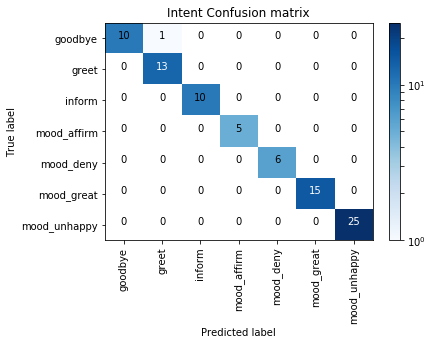

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  0.9775529042760154
INFO:rasa_nlu.evaluate:Precision: 0.9780517143345049
INFO:rasa_nlu.evaluate:Accuracy:  0.9787985865724381
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

      group       0.93      0.72      0.81        18
  no_entity       0.98      1.00      0.99       265

avg / total       0.98      0.98      0.98       283



In [8]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)


# Part 2: Handling the dialogue
We have taught our chatbot how to understand user inputs. Now, it's time to teach our chatbot how to make responses by training a dialogue management model using Rasa Core.

## Writing Stories
The training data for dialogue management models is called stories. A story is an actual conversation where user inputs are expressed as intents as well as corresponding entities, and chatbot responses are expressed as actions.

Let's take a look into the format of the stories in more detail:

A story starts with ## and you can give it a name. Lines that start with * are messages sent by the user. Although you don't write the actual message, but rather the intent (and the entities) that represent what the user means. Lines that start with - are actions taken by your bot. In this case all of our actions are just messages sent back to the user, like utter_greet, but in general an action can do anything, including calling an API and interacting with the outside world.

In [9]:
stories_md = """
## happy path               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_great               <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
## sad path 1               <!-- this is already the start of the next story -->
* greet
  - utter_greet             <!-- action the bot should execute -->
* mood_unhappy
  - utter_ask_picture
* inform{"animal":"dog"}  
  - action_retrieve_image
  - utter_did_that_help
* mood_affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - utter_ask_picture
* inform{"group":"cat"}
  - action_retrieve_image
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## sad path 3
* greet
  - utter_greet
* mood_unhappy{"group":"puppy"}
  - action_retrieve_image
  - utter_did_that_help
* mood_affirm
  - utter_happy
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear

## say goodbye
* goodbye
  - utter_goodbye

## fallback
- utter_unclear

"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


## Defining a Domain
The domain specifies the universe that the bot operates in. In chatbot's world this universe consists of intents and entities as well as the actions which appear in training stories. The domain can also contain the templates for the answers a chabot should use to respond to the user and slots which will help the chatbot to keep track of the context. Let's look into the domain of our bot:

In [10]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_deny
- mood_great
- mood_unhappy
- inform

slots:
  group:
    type: text
    
entities:
- group

actions:
- utter_greet
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear
- utter_ask_picture
- __main__.ApiAction

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
  
  utter_ask_picture:
  - text: "To cheer you up, I can show you a cute picture of a dog, cat or a bird. Which one do you choose?"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Adding Custom Actions
The responses of the chatbot can be more than just simple text responses - we can call an API to retrieve some data which can later be used to create a response to user input. Let's create a custom action for our bot which, when predicted, will make an API and retrieve a picture of a dog, a cat or a bird, depending on which was specified by the user. The bot will know which type of picture should be received by retrieving the value of the slot group.

In [11]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet
from IPython.core.display import Image, display

import requests

class ApiAction(Action):
    def name(self):
        return "action_retrieve_image"

    def run(self, dispatcher, tracker, domain):
        
        group = tracker.get_slot('group')
        
        r = requests.get('http://shibe.online/api/shibes?count=[1-100]&urls=[true/false]&httpsUrls=[true/false]'.format(group))
        response = r.content.decode()
        response = response.replace('["',"")
        response = response.replace('"]',"")
   
        
        #display(Image(response[0], height=550, width=520))
        dispatcher.utter_message("Here is something to cheer you up: {}".format(response))

## Training your Dialogue Model
Now we are good to train the dialogue management model. We can specify what policies should be used to train it - in this case, the model is a neural network implemented in Keras which learns to predict which action to take next. We can also tweak the parameters of what percentage of training examples should be used for validation and how many epochs should be used for training.

In [12]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.1)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=200
)

agent.persist('models/dialogue')

INFO:apscheduler.scheduler:Scheduler started
Using TensorFlow backend.
Processed Story Blocks: 100%|██████████| 7/7 [00:00<00:00, 98.87it/s, # trackers=14]
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 229/229 [00:14<00:00, 15.62it/s, # actions=263]
INFO:rasa_core.featurizers:Created 263 action examples.
Processed actions: 263it [00:00, 269.63it/s, # examples=263]
INFO:rasa_core.policies.memoization:Memorized 263 unique action examples.
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 229/229 [00:13<00:00, 17.34it/s, # actions=263]
INFO:rasa_core.featurizers:Created 263 action examples.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 5, 18)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6528      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 297       
_________________________________________________________________
activation_1 (Activation)    (None, 9)                 0         
Total params: 6,825
Trainable params: 6,825
Non-trainable params: 0
_________________________________________________________________


INFO:rasa_core.policies.keras_policy:Fitting model with 263 total samples and a validation split of 0.0


Epoch 1/200
263/263 [==============================] - ETA: 10s - loss: 2.2361 - acc: 0.12 - 2s 6ms/step - loss: 2.1510 - acc: 0.1711
Epoch 2/200
263/263 [==============================] - ETA: 0s - loss: 2.0558 - acc: 0.312 - 0s 228us/step - loss: 2.0350 - acc: 0.3650
Epoch 3/200
263/263 [==============================] - ETA: 0s - loss: 1.9512 - acc: 0.562 - 0s 250us/step - loss: 1.9331 - acc: 0.4639
Epoch 4/200
263/263 [==============================] - ETA: 0s - loss: 1.8259 - acc: 0.500 - 0s 205us/step - loss: 1.8328 - acc: 0.4677
Epoch 5/200
263/263 [==============================] - ETA: 0s - loss: 1.7603 - acc: 0.500 - 0s 220us/step - loss: 1.7569 - acc: 0.4677
Epoch 6/200
263/263 [==============================] - ETA: 0s - loss: 1.6719 - acc: 0.500 - 0s 205us/step - loss: 1.7099 - acc: 0.4677
Epoch 7/200
263/263 [==============================] - ETA: 0s - loss: 1.6713 - acc: 0.500 - 0s 205us/step - loss: 1.6677 - acc: 0.4677
Epoch 8/200
263/263 [=============================

Epoch 52/200
263/263 [==============================] - ETA: 0s - loss: 0.5689 - acc: 0.812 - 0s 243us/step - loss: 0.5364 - acc: 0.8745
Epoch 53/200
263/263 [==============================] - ETA: 0s - loss: 0.4865 - acc: 0.843 - ETA: 0s - loss: 0.5144 - acc: 0.886 - 0s 296us/step - loss: 0.5106 - acc: 0.8897
Epoch 54/200
263/263 [==============================] - ETA: 0s - loss: 0.5007 - acc: 0.812 - 0s 231us/step - loss: 0.4694 - acc: 0.8935
Epoch 55/200
263/263 [==============================] - ETA: 0s - loss: 0.5923 - acc: 0.718 - ETA: 0s - loss: 0.4984 - acc: 0.837 - 0s 311us/step - loss: 0.4974 - acc: 0.8593
Epoch 56/200
263/263 [==============================] - ETA: 0s - loss: 0.5098 - acc: 0.812 - ETA: 0s - loss: 0.4562 - acc: 0.916 - 0s 315us/step - loss: 0.4672 - acc: 0.9087
Epoch 57/200
263/263 [==============================] - ETA: 0s - loss: 0.3476 - acc: 0.937 - ETA: 0s - loss: 0.4549 - acc: 0.914 - 0s 410us/step - loss: 0.4540 - acc: 0.9163
Epoch 58/200
263/263 [====

Epoch 107/200
263/263 [==============================] - ETA: 0s - loss: 0.0764 - acc: 1.000 - ETA: 0s - loss: 0.1435 - acc: 0.977 - 0s 303us/step - loss: 0.1536 - acc: 0.9772
Epoch 108/200
263/263 [==============================] - ETA: 0s - loss: 0.1615 - acc: 0.968 - 0s 216us/step - loss: 0.1531 - acc: 0.9734
Epoch 109/200
263/263 [==============================] - ETA: 0s - loss: 0.1783 - acc: 1.000 - 0s 193us/step - loss: 0.1476 - acc: 0.9696
Epoch 110/200
263/263 [==============================] - ETA: 0s - loss: 0.1587 - acc: 1.000 - 0s 224us/step - loss: 0.1613 - acc: 0.9582
Epoch 111/200
263/263 [==============================] - ETA: 0s - loss: 0.1219 - acc: 1.000 - 0s 235us/step - loss: 0.1409 - acc: 0.9772
Epoch 112/200
263/263 [==============================] - ETA: 0s - loss: 0.0954 - acc: 0.968 - 0s 205us/step - loss: 0.1602 - acc: 0.9468
Epoch 113/200
263/263 [==============================] - ETA: 0s - loss: 0.2479 - acc: 0.906 - 0s 231us/step - loss: 0.1682 - acc: 0.9

263/263 [==============================] - ETA: 0s - loss: 0.0697 - acc: 0.968 - 0s 205us/step - loss: 0.0780 - acc: 0.9810
Epoch 164/200
263/263 [==============================] - ETA: 0s - loss: 0.0752 - acc: 1.000 - 0s 220us/step - loss: 0.0722 - acc: 0.9886
Epoch 165/200
263/263 [==============================] - ETA: 0s - loss: 0.0434 - acc: 0.968 - 0s 254us/step - loss: 0.0842 - acc: 0.9772
Epoch 166/200
263/263 [==============================] - ETA: 0s - loss: 0.0174 - acc: 1.000 - ETA: 0s - loss: 0.0591 - acc: 1.000 - 0s 281us/step - loss: 0.0616 - acc: 0.9962
Epoch 167/200
263/263 [==============================] - ETA: 0s - loss: 0.0600 - acc: 1.000 - 0s 212us/step - loss: 0.0691 - acc: 0.9924
Epoch 168/200
263/263 [==============================] - ETA: 0s - loss: 0.0594 - acc: 0.968 - 0s 212us/step - loss: 0.0639 - acc: 0.9886
Epoch 169/200
263/263 [==============================] - ETA: 0s - loss: 0.0162 - acc: 1.000 - 0s 235us/step - loss: 0.0636 - acc: 0.9848
Epoch 170/

## Starting up the bot (with NLU)
Now it's time for the fun part - starting the agent and chatting with it. We are going to start the Agent by loading our just trained dialogue model and using the previously trained nlu model as an interpreter for incoming user inputs.

In [13]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


## Talking to the Bot (with NLU)
Let's have a chat!

In [14]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])

Your bot is ready to talk! Type your messages here or send 'stop'
stop


In [15]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])

Your bot is ready to talk! Type your messages here or send 'stop'
stop


## Evaluation of the dialogue model
As with the NLU model, instead of just subjectively testing the model, we can also evaluate the model on a dataset. You'll be using the training data set again, but usually you'd use a test data set separate from the training data.

Processed Story Blocks: 100%|██████████| 7/7 [00:00<?, ?it/s]
INFO:rasa_core.evaluate:Evaluating 7 stories
Progress:
100%|██████████| 7/7 [00:04<00:00,  1.53it/s]
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
                       precision    recall  f1-score   support

        action_listen       1.00      1.00      1.00        18
action_retrieve_image       1.00      1.00      1.00         3
    utter_ask_picture       1.00      1.00      1.00         2
  utter_did_that_help       1.00      1.00      1.00         3
        utter_goodbye       1.00      1.00      1.00         3
          utter_greet       1.00      1.00      1.00         4
          utter_happy       1.00      1.00      1.00         5
        utter_unclear       1.00      1.00      1.00         1

          avg / total       1.00      1.00      1.00        39

INFO:rasa_nlu.evaluate:Confusion matrix, wi

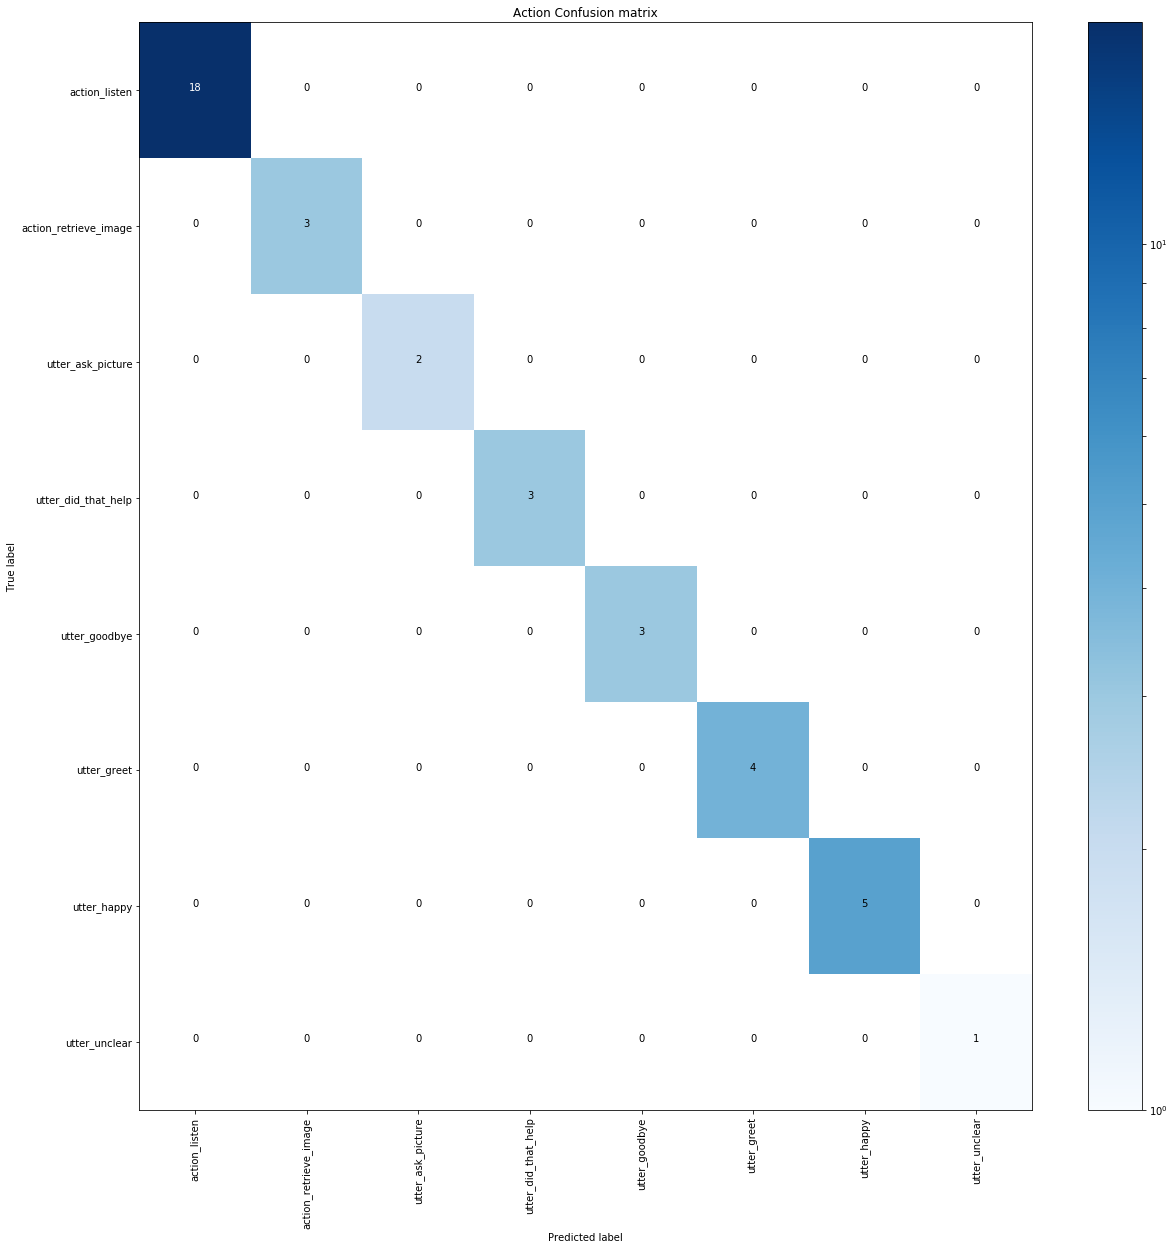

In [16]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")